In [1]:
import functools

import numpy as np
from collections import defaultdict
# from scipy.special import expit

import pyspark.sql.functions as psf
from pyspark.sql.functions import udf
from pyspark.sql.functions import col
import pyspark.sql as pysql
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, MapType, ArrayType, FloatType, BooleanType
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
# from operator import add
# from functools import reduce

pd.set_option('display.max_columns', None)
spark.conf.set('spark.sql.session.timeZone', 'UTC')

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
348,application_1653679151702_0350,pyspark,idle,Link,Link,gakumar,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Data Preparation

In [2]:
date = '2022-06-19'
hr = '04'
env = 'production'
oc_stats_s3_path = 's3://mist-secorapp-'+env+'/oc-stats-analytics/oc-stats-analytics-'+env+'/dt='+date+'/hr='+hr+'/*'

print(oc_stats_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://mist-secorapp-production/oc-stats-analytics/oc-stats-analytics-production/dt=2022-06-19/hr=04/*

In [3]:
df_remote = spark.read.parquet(oc_stats_s3_path)

rank_window = pysql.Window().partitionBy(psf.col('switch_id')).orderBy(
        psf.col("when").desc())
df_remote = df_remote.withColumn("rank", psf.rank().over(rank_window)) \
    .filter(psf.col("rank")==1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# Site List to Check
# site_list = {'7cf7111a-b9e9-48df-86ef-230fae9c5a58', '10448f99-05ff-423f-b48e-696413d4c019', '04d8a2d8-4b9c-4314-b1fb-7cec586f437d', 'd7e0e251-82a9-4a84-9622-844ca4fd1e4b', '60a31a89-4a68-4a46-a58e-0a8cf866ef7a', '9c103626-af9d-41f4-ac8c-254cb61863f6', '128aa802-6601-4197-bb38-c9c2ae2d3994', 'f8a3c86b-6472-488e-a6c9-ee42d70a6f44', 'd08ccc2b-93f7-4d4a-b4dd-12b34eeb1aa8', '0bc1ffb9-7815-4a4d-ba59-f674dd057d67', 'cd70c572-6191-41f7-9d54-885e8121619c', '03baf34e-0186-4037-b8dc-88c80649532d', '2db0c421-8401-43bf-9a5c-0d901628a5e2', '99a28ff4-3d06-4762-ae04-9b362307cd12', '766c8be2-dc5c-4e3a-b88d-a14ce6143492', '8b3b9c76-4d5f-4800-a297-9aa6ae23da1b', '884e891e-2454-48a8-9cfb-aa90a8206b88', '98665da2-614a-41bb-95d2-d7adc55ff5df', '898b809b-2b46-443d-babb-c374ce638b94', 'ad7a3544-2c1f-4ffe-beca-ad373cedafaf', '06de2a1d-e72f-4d10-8cb4-34286e4a859e', 'fe45458d-e425-4e65-85b6-1890bcb7ad70'}

# New model's loop site_list
# site_list = {'72706575-6eec-42c2-80d8-5ec2a27d232b', '04d8a2d8-4b9c-4314-b1fb-7cec586f437d', '21cae898-ca82-4a4f-8138-00bca7931f87', '7933e726-0927-440f-b0f6-0dffeb54b8a2', '13cbd57d-9876-4926-80ee-3703970d66fd', '8e443f2e-914e-43fc-91e6-0d732c82d610', 'ba5c1279-11bc-49e5-94d4-4a8bd9973a87', '6647863e-ec58-4390-9c65-a68dcf270d24', '128aa802-6601-4197-bb38-c9c2ae2d3994', 'f8a3c86b-6472-488e-a6c9-ee42d70a6f44', 'cdc7db33-da6e-4186-bd45-95d62f58c9aa', 'd72db198-cb28-48d6-b931-dfe5782e8fe6', '3735ed13-1a9d-4b43-af35-a0a9d829b9cc', '1f43a318-19ce-4917-9fb7-5418e6ab9296', 'd86aaba3-eead-454e-8a83-0131904650b4', 'd8f38c5e-6c95-4dbd-953d-835f5adbf316', '0bc1ffb9-7815-4a4d-ba59-f674dd057d67', '34d1fe77-f972-4c05-91c0-3eefedd9e55b', 'b7294cc0-0c73-4a74-b7f6-761b8fd09948', '2fab5da3-9dab-47f8-9cc9-a76438b5a02e', '10811140-1428-4592-88e5-64ca908a08b2', '766c8be2-dc5c-4e3a-b88d-a14ce6143492', '3057fa2b-e5ee-40fb-a727-82e65a62ae4a', '61236b85-d4d6-4289-b093-3ff48a9adb65', '37af3f6b-7d8c-4605-a804-d603629c2e80', '061f9433-7f3a-44f0-8344-542a2e373f62', '884e891e-2454-48a8-9cfb-aa90a8206b88', 'd53c6e86-bc7c-4936-906f-38db5aec207d', '28d63b6b-a652-4337-b9c5-05fc5c60c6a3', 'ea92e8fe-542b-44b5-bab8-d215cd13e82a', '8ce75d2d-d85d-4d54-bfee-78d4f9acf0e3', 'ad7a3544-2c1f-4ffe-beca-ad373cedafaf', 'f2860e64-78af-4708-9b64-a5b1299bf952', '4d6abae0-f9eb-40fe-9db2-ccb630d1261b', '99becb91-9980-4653-83f0-7a222bad655c', '8774f51e-0b05-4756-8b99-6cda9bfe52f8', '77a8fec7-dce8-4486-843f-14ec33a99833', '54f41c7f-42c2-483c-a073-797964bfffed', 'd720d950-1ac5-4eba-bf4f-8ae3a4cd74d6', '88a9ac0f-f166-4a7a-aeff-e3b0f37c0844', '9c103626-af9d-41f4-ac8c-254cb61863f6', '1ea0c03c-5b9a-4f10-9933-b14b9a51d7a8', '2dc50fbc-25fa-4b4f-b05f-21e2e0601bee', '35027fd3-cf0d-45f4-a9f6-499779138e07', '03baf34e-0186-4037-b8dc-88c80649532d', 'cd70c572-6191-41f7-9d54-885e8121619c', '3596d587-31e5-4acd-8fe5-8ac2031d5f63', '2db0c421-8401-43bf-9a5c-0d901628a5e2', '8a1cd140-7a1a-4642-861e-9fa96e625d81', 'af86fea5-a434-42a6-9a13-45706c24593f', '2ddfedd5-c1c5-4b8f-be44-35872222b41e', '58520b3b-938c-40b6-942f-cda40bd72139', '4e65be85-2fbf-41d4-8f83-c04adf7a132a', '69bef04f-321d-4333-94d5-45adfdcff883', '98665da2-614a-41bb-95d2-d7adc55ff5df', 'c37a2b52-0e60-47aa-a63f-f589bdf4b90b', 'e4c07082-683b-4c4e-8e4c-336f8d5eb215', '898b809b-2b46-443d-babb-c374ce638b94', '319f74f5-0e67-403b-8464-363f27d92000', '10448f99-05ff-423f-b48e-696413d4c019', '0e9177ea-e28f-4741-9595-76ae7b88f755', 'a7583402-7806-4970-8b65-fabf0034822e', 'd0508aef-35e8-40cc-a7a1-c62ba148be58', '785bd2d2-fb41-4c0d-a049-40fe0983a159', '7e9f985d-dfc3-4f23-bf71-33130bd7223f', '048753c1-f5ec-4ccb-9f2e-4fcd3291e542', 'c6987f0f-c68f-43d9-993e-e9c1d63fc4d7', '4747d091-2bda-426d-bb6d-a72b49fb5a33', '1cd9722c-b592-11e5-bb31-02e208b2d34f', 'a9f8911d-ff72-4e01-8b81-cfc7632ebba3', '8bb1508b-d45b-4282-b1c5-fc5916332295', '25fa40c3-567a-4855-90c6-27a40fbb4707', 'd751e26d-fc77-4086-a970-030f536e54e2', 'dd426894-e024-412f-99ee-0e02ad7f711a', 'f5fcbee5-fbca-45b3-8bf1-1619ede87879', '1885e2f0-76d4-4b2b-8d60-63a3f4af7ee7', '429674a8-366a-42bb-bb42-7d39c5cc553e', '8b3b9c76-4d5f-4800-a297-9aa6ae23da1b', '76d6f4b2-ce21-4b80-bfef-b2cc06d8b4ca', 'ebd01f93-0304-4039-b9dd-fad9b39ec97e', 'fe45458d-e425-4e65-85b6-1890bcb7ad70', '7cf7111a-b9e9-48df-86ef-230fae9c5a58', '09df1500-f1b3-4501-a805-7af21a1fb90f', 'd7e0e251-82a9-4a84-9622-844ca4fd1e4b', 'f14412f0-319c-4556-9fbf-92d792ad326b', '462562db-5118-4581-bfc7-0fc9d86eafc6', '2c355e9f-8cdd-4aeb-811e-26907afb3a46', 'ae3e8f70-fbb6-447d-8804-bbbdec0fd7be', 'ee04d360-97e9-44b6-bcce-2688cd922b04', '60a31a89-4a68-4a46-a58e-0a8cf866ef7a', 'b065a63a-f500-428a-80bf-9bac6301317e', '3604f709-045b-459a-b8df-45a399ab56e4', 'd08ccc2b-93f7-4d4a-b4dd-12b34eeb1aa8', 'b3610203-d3ca-4511-803c-dca6f17c470c', '5af3f529-36ee-40b3-8bcc-838370a1e7af', 'c075d9b5-3e73-44ea-910c-de7f9100b966', 'ec6ecdc1-e040-4cf7-b6f8-eb2b7f2b9a84', '99a28ff4-3d06-4762-ae04-9b362307cd12', '6f4a9f45-d1c7-406c-b993-18a524f8701d', '3d214c78-4eae-4050-b861-fc2e6c6ff4a8', 'ed68b481-c760-4722-aa8a-233bd919da5a', '1645f666-d2c8-4574-a300-b52d49ce4167', '06de2a1d-e72f-4d10-8cb4-34286e4a859e'}

site_list = {'20f8ab3e-2bc9-4be3-ac1a-ad89dc28f643', '38ca4749-cf30-4039-9bd8-7deca94c791f'}

print(len(site_list))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2

In [5]:
df_remote = df_remote.filter(psf.col("site_id").isin(site_list))

sel_cols = ['site_id', 'switch_id', psf.explode("uplink_combined").alias("name")]
curr_df_check = df_remote.select(*sel_cols) \
    .withColumn("uplink_curr", psf.lit(1)) 

sel_cols = ['site_id', 'switch_id', psf.explode("uplink_combined_v1").alias("name")]
old_df_check = df_remote.select(*sel_cols) \
    .withColumn("uplink_old", psf.lit(1)) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
sel_cols = ["site_id", "switch_id", psf.explode("interfaces").alias("i"), "clients"]
final_cols = ["site_id", "switch_id", "i.name", "i.remote_chassis_id", "clients"]
df_remote = df_remote.select(*sel_cols) \
    .select(*final_cols).distinct()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
df_remote.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1378

In [8]:
df_remote.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['site_id', 'switch_id', 'name', 'remote_chassis_id', 'clients']

In [9]:
# df_remote.select("site_id", "switch_id", "name").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
# df_remote.select("site_id", "switch_id", "name", "remote_chassis_id").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
df_remote = df_remote.join(curr_df_check, ["site_id", "switch_id", "name"], how="left")
# df_remote.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
df_remote = df_remote.join(old_df_check, ["site_id", "switch_id", "name"], how="left").persist()
df_remote.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1378

In [13]:
old_df_check.count(), curr_df_check.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(25, 22)

In [14]:
df_remote.filter(psf.col("uplink_old")==1).count(), df_remote.filter(psf.col("uplink_curr")==1).count(),

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(25, 22)

In [15]:
old_df_check.filter(psf.col("site_id").isin(site_list)).count(), curr_df_check.filter(psf.col("site_id").isin(site_list)).count()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(25, 22)

In [16]:
df_remote.agg(psf.sum("uplink_old").alias("old_sum"), psf.sum("uplink_curr").alias("curr_sum")).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------+
|old_sum|curr_sum|
+-------+--------+
|     25|      22|
+-------+--------+

In [17]:
df_remote.filter((psf.col("uplink_old")==1)|(psf.col("uplink_curr")==1)).count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

30

In [18]:
df_remote.filter(psf.col("remote_chassis_id")=='').count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1075

In [19]:
df_remote.filter(((psf.col("uplink_old")==1)|(psf.col("uplink_curr")==1))&(psf.col("remote_chassis_id")=='')).count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

In [20]:
df_remote.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- site_id: string (nullable = true)
 |-- switch_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- remote_chassis_id: string (nullable = true)
 |-- clients: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- vlan_name: string (nullable = true)
 |    |    |-- mac: string (nullable = true)
 |    |    |-- flags: string (nullable = true)
 |    |    |-- age: integer (nullable = true)
 |    |    |-- iface_name: string (nullable = true)
 |    |    |-- vlan_id: integer (nullable = true)
 |    |    |-- ip: string (nullable = true)
 |    |    |-- hostname: string (nullable = true)
 |    |    |-- dhcpbound: integer (nullable = true)
 |    |    |-- username: string (nullable = true)
 |    |    |-- group: string (nullable = true)
 |    |    |-- auth_state: string (nullable = true)
 |    |    |-- auth_method: string (nullable = true)
 |-- uplink_curr: integer (nullable = true)
 |-- uplink_old: integer (nullable = true)

In [21]:
df_remote.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['site_id', 'switch_id', 'name', 'remote_chassis_id', 'clients', 'uplink_curr', 'uplink_old']

In [22]:
sel_cols = ['site_id', 'switch_id', 'name', 'remote_chassis_id', psf.explode('clients').alias("c"), 'uplink_curr', 'uplink_old']
final_cols = ['site_id', 'switch_id', 'name', 'remote_chassis_id', 'c.iface_name', 'c.mac', 'uplink_curr', 'uplink_old']
df_client_mac = df_remote.select(*sel_cols).select(*final_cols)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
df_remote.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1378

In [24]:
df_client_mac = df_client_mac.filter(psf.col("name")==psf.col("iface_name")) \
    .select("site_id", 'switch_id', 'name', 'iface_name', 'mac')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
df_client_mac.count(), df_client_mac.select("site_id", 'switch_id', 'name').distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(547, 477)

In [26]:
rank_window = pysql.Window().partitionBy(psf.col('site_id'), psf.col('switch_id'), psf.col('name')).orderBy(
        psf.col("mac").desc())
df_client_mac = df_client_mac.withColumn("rank", psf.rank().over(rank_window)) \
    .filter(psf.col("rank")==1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
# Checking multiple macs for client_id
df_client_mac.groupBy("site_id", 'switch_id', 'name') \
    .agg(psf.countDistinct("mac").alias("cnt")).filter(psf.col("cnt")>1).show(10, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+----+---+
|site_id|switch_id|name|cnt|
+-------+---------+----+---+
+-------+---------+----+---+

In [28]:
# df_client_mac.filter((psf.col("switch_id")=='1039e9cd98f4')&(psf.col("name")=='ge-1/0/5')).show()
df_client_mac.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+---------+----------+------------+----+
|             site_id|   switch_id|     name|iface_name|         mac|rank|
+--------------------+------------+---------+----------+------------+----+
|38ca4749-cf30-403...|b48a5f0cd179|ge-0/0/36| ge-0/0/36|18dbf237e3c8|   1|
|20f8ab3e-2bc9-4be...|f07cc77b9b80|ge-0/0/19| ge-0/0/19|d4dc0922c704|   1|
|20f8ab3e-2bc9-4be...|f07cc77b9b80|ge-0/0/13| ge-0/0/13|0012e5065173|   1|
|20f8ab3e-2bc9-4be...|f07cc77b567e| xe-0/1/0|  xe-0/1/0|78507c6ecf9a|   1|
|20f8ab3e-2bc9-4be...|f07cc77b5759|ge-0/0/40| ge-0/0/40|045d4be355ba|   1|
|20f8ab3e-2bc9-4be...|f07cc77b82fa| ge-0/0/9|  ge-0/0/9|d4dc0922c60f|   1|
|38ca4749-cf30-403...|b48a5f0cb41a|ge-0/0/21| ge-0/0/21|accc8ecbb5c4|   1|
|20f8ab3e-2bc9-4be...|f07cc77ba532|ge-0/0/26| ge-0/0/26|d4dc0922c317|   1|
|38ca4749-cf30-403...|b48a5f07e35f| ge-0/0/1|  ge-0/0/1|accc8ecbb604|   1|
|38ca4749-cf30-403...|b48a5f07c095|ge-0/0/23| ge-0/0/23|accc8e776cd0|   1|
|38ca4749-cf30-403...|b48

In [29]:
remove_site_clients = list(df_client_mac.groupBy("site_id", 'switch_id', 'name') \
    .agg(psf.countDistinct("mac").alias("cnt")) \
    .filter(psf.col("cnt")>1).select("site_id").distinct().toPandas()['site_id'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
# 187
print(len(remove_site_clients))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

In [31]:
df_client_mac = df_client_mac.filter(~(psf.col("site_id").isin(remove_site_clients)))
df_client_mac.count(), df_client_mac.select("site_id", 'switch_id', 'name').distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(529, 477)

In [32]:
df_client_mac = df_client_mac.select('site_id', 'switch_id', 'name', 'iface_name', 'mac').distinct()
df_client_mac.count(), df_client_mac.select("site_id", 'switch_id', 'name').distinct().count()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(477, 477)

In [33]:
# df_remote.join(df_client_mac, ["site_id", 'switch_id', 'name'], how="left").count()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
df_remote = df_remote.join(df_client_mac, ["site_id", 'switch_id', 'name'], how="left")
df_remote.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1378

In [35]:
df_remote = df_remote.filter(~(psf.col("site_id").isin(remove_site_clients))).persist()
df_remote.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1378

In [36]:
df_remote = df_remote.withColumn("remote_mac", 
                               psf.when(psf.col("remote_chassis_id") == '', 
                                        psf.col("mac")).otherwise(psf.col("remote_chassis_id")))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
sel_cols = ["switch_id", "name", "remote_chassis_id", "mac", "remote_mac"]
df_remote.filter(~(psf.col("remote_mac").isNull())).select(*sel_cols).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+---------+-----------------+------------+------------+
|   switch_id|     name|remote_chassis_id|         mac|  remote_mac|
+------------+---------+-----------------+------------+------------+
|b48a5f0cd179|ge-0/0/36|     0010492be5ad|18dbf237e3c8|0010492be5ad|
|f07cc77b9b80|ge-0/0/19|     d4dc0922c704|d4dc0922c704|d4dc0922c704|
|f07cc77b9b80|ge-0/0/13|                 |0012e5065173|0012e5065173|
|f07cc77b567e| xe-0/1/0|     78507c6ecf9a|78507c6ecf9a|78507c6ecf9a|
|f07cc77b5759|ge-0/0/40|                 |045d4be355ba|045d4be355ba|
|f07cc77b82fa| ge-0/0/9|     d4dc0922c60f|d4dc0922c60f|d4dc0922c60f|
|b48a5f0cb41a|ge-0/0/21|     accc8ecbb5c4|accc8ecbb5c4|accc8ecbb5c4|
|f07cc77ba532|ge-0/0/26|     d4dc0922c317|d4dc0922c317|d4dc0922c317|
|b48a5f07e35f| ge-0/0/1|     accc8ecbb604|accc8ecbb604|accc8ecbb604|
|b48a5f07c095|ge-0/0/23|     accc8e776cd0|accc8e776cd0|accc8e776cd0|
|b48a5f07de3d| ge-0/0/9|     0010492be5f7|64006a76f8f4|0010492be5f7|
|b48a5f07e35f|ge-0/0/45|          

In [38]:
df_remote = df_remote.fillna('')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
df_remote.filter(psf.col("remote_mac")=='').count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

901

In [40]:
# 285 rows
missing_remote_site_list = list(df_remote.filter(((psf.col("uplink_curr")==1)|(psf.col("uplink_old")==1))&(psf.col("remote_mac")=='')).select("site_id").distinct().toPandas()["site_id"])
print(len(missing_remote_site_list))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

In [41]:
df_remote = df_remote.filter(~(psf.col("site_id").isin(missing_remote_site_list)))
df_remote.count(), df_remote.select("site_id").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(1378, 2)

In [42]:
df_remote.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['site_id', 'switch_id', 'name', 'remote_chassis_id', 'clients', 'uplink_curr', 'uplink_old', 'iface_name', 'mac', 'remote_mac']

### Graph Formation and Check

In [43]:
# val_graphs_s3_path = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/val_graphs_test_site/"

# val_graphs_s3_path = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/val_graphs_14jun/"

# val_graphs_s3_path = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/val_graphs_13jun_all_loop_sites/"

# df_remote.repartition(1).write.parquet(val_graphs_s3_path, mode='overwrite')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
# df_remote = spark.read.parquet(val_graphs_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
# site_list = set(
#     df_remote.select('site_id').toPandas()['site_id']
# )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
df_oc = spark.read.parquet(oc_stats_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
# df_oc.filter(psf.col("site_id").isin(site_list)).select("site_id", "org_id").distinct().show(200, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
site_id = '38ca4749-cf30-4039-9bd8-7deca94c791f'
df_curr = df_remote.filter((psf.col("site_id")==site_id)&(psf.col("uplink_curr")==1)) \
    .select("switch_id", "remote_mac").toPandas()
df_old = df_remote.filter((psf.col("site_id")==site_id)&(psf.col("uplink_old")==1)) \
    .select("switch_id", "remote_mac").toPandas()
switch_set = set(df_remote.filter(psf.col("site_id")==site_id).select("switch_id").distinct().toPandas()["switch_id"])
remote_set = set(df_remote.filter((psf.col("site_id")==site_id)&((psf.col("uplink_curr")==1)|(psf.col("uplink_old")==1))).select("remote_mac").distinct().toPandas()["remote_mac"])
device_set = switch_set | remote_set

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
device_set

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'b48a5f0cb41a', 'b48a5f07d6d3', 'b48a5f07c095', 'a4e11ab652b9', 'b48a5f07af79', 'b48a5f07de3d', 'b48a5f0cd179', 'b48a5f07e35f', 'a4e11ab7c644'}

In [50]:
print(len(switch_set), len(remote_set), len(device_set))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

9 7 9

In [51]:
edge_curr = list(zip(df_curr.switch_id, df_curr.remote_mac))
edge_old = list(zip(df_old.switch_id, df_old.remote_mac))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
import networkx as nx

G_curr = nx.DiGraph()
G_old = nx.DiGraph()

color_map_curr = []
color_map_old = []

for dev in device_set:
    G_curr.add_node(dev)
    G_old.add_node(dev)
    
    if dev in switch_set:
        color_map_curr.append("yellow")
        color_map_old.append("orange")
    else:
        color_map_curr.append("pink")
        color_map_old.append("pink")
        
    
for i in range(len(edge_curr)):
    G_curr.add_edge(edge_curr[i][0], edge_curr[i][1])
    
for i in range(len(edge_old)):
    G_old.add_edge(edge_old[i][0], edge_old[i][1])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

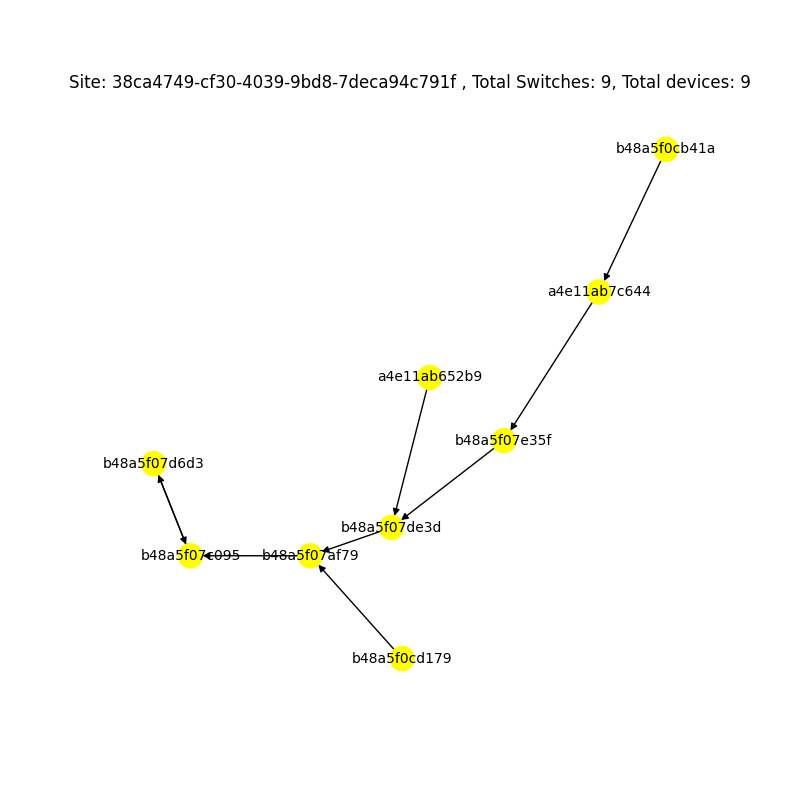

In [53]:
plt.clf()
plt.figure(figsize=(8, 8))
plt.title("Site: "+site_id+" , Total Switches: "+str(len(switch_set))+", Total devices: "+str(len(device_set)))
my_pos = nx.spring_layout(G_curr, k=0.15, iterations=20)
nx.draw(G_curr, pos=my_pos, with_labels=True, font_size=10, node_color=color_map_curr)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

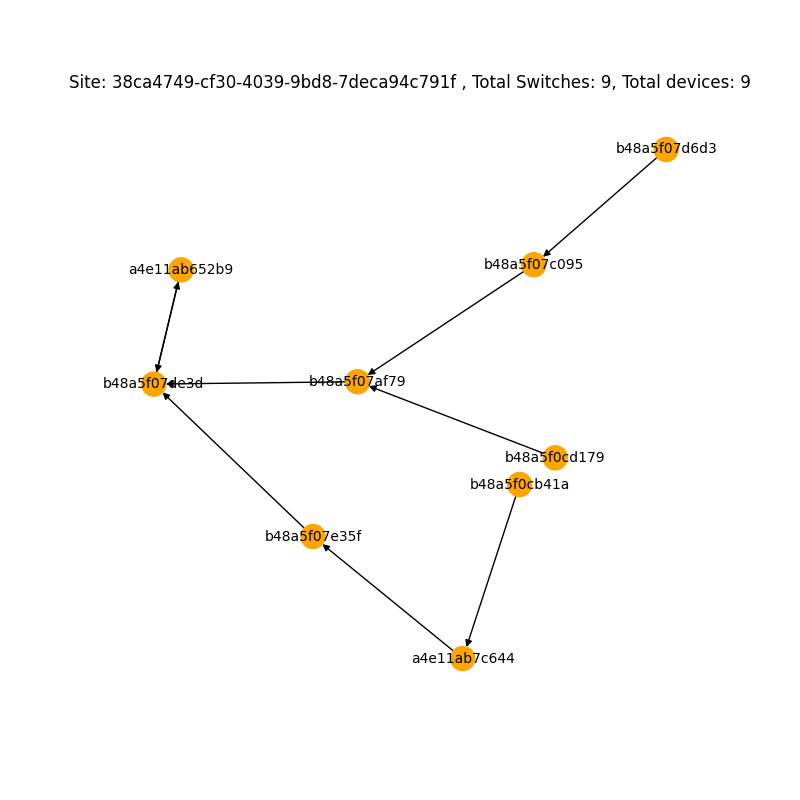

In [55]:
plt.clf()
plt.figure(figsize=(8, 8))
plt.title("Site: "+site_id+" , Total Switches: "+str(len(switch_set))+", Total devices: "+str(len(device_set)))
my_pos = nx.spring_layout(G_old, k=0.15, iterations=20)
nx.draw(G_old, pos=my_pos, with_labels=True, font_size=10, node_color=color_map_old)

%matplot plt

# Some Calculations

In [10]:
common_sites = {'4e8627d1-72cc-41fa-96e9-a99c60acc604', '72706575-6eec-42c2-80d8-5ec2a27d232b', '1cca5535-2f46-409c-b692-2f6c69cf5e96', 'a985f593-88e6-4e74-b9af-6048a83851ef', 'cd9af06f-58bd-4bca-86f4-8b4504b758e4', '7933e726-0927-440f-b0f6-0dffeb54b8a2', 'db966083-12c3-4c94-acc3-ac5e52ef42dd', 'a6caef99-589b-409d-996b-9d1bbe71e733', 'ba5c1279-11bc-49e5-94d4-4a8bd9973a87', '5d730b5c-65d2-4061-8b45-c3020c36a087', '6647863e-ec58-4390-9c65-a68dcf270d24', '9cdba47d-cc74-4520-bf73-fd776a8788f8', '90c35de6-f43a-4e66-af30-2a9fcec491b0', 'c69b26ea-baf0-4d37-9f8b-11560a0f78ab', 'b6311022-1133-4683-bcdf-8e0fcec52927', 'd72db198-cb28-48d6-b931-dfe5782e8fe6', '3735ed13-1a9d-4b43-af35-a0a9d829b9cc', '7747f55d-0673-45ca-a32c-c97acde1b438', '86766442-a03b-409b-98aa-a77a4684a311', '1f43a318-19ce-4917-9fb7-5418e6ab9296', 'df4e49a3-f9b5-412f-8b86-ec9d63aa3b82', 'f825b52b-87a1-43d1-844d-2e3cec26924d', '02284e73-03b4-420f-b426-b25290cb9e8a', '34d1fe77-f972-4c05-91c0-3eefedd9e55b', '7b2e6f79-8043-4f0a-a264-cfe099172e04', 'b39dd655-6d59-4050-8aca-c6985276e8df', '218aa8e0-5d72-4d09-ac08-b966956e10ca', 'b7294cc0-0c73-4a74-b7f6-761b8fd09948', '061f9433-7f3a-44f0-8344-542a2e373f62', '73162a6e-3c77-4103-b8dc-c516c5386b31', 'e536d9a5-f4e0-4a2b-8b55-4847832964e4', 'd53c6e86-bc7c-4936-906f-38db5aec207d', '006be760-099e-4df3-b935-c1f547e85a5f', '746a4662-931a-4cdf-b512-13c38e1a2aee', '65727953-f04c-413d-a0c3-92cc202e6128', 'b87125e3-759b-4258-bae3-5e6dc7857d45', '6cf57059-af1c-4bac-a2cc-524144e3d5fc', 'b444ec5d-524f-4f0c-a8f0-a6100f71a461', '6ba97cee-8566-4cf0-a560-d35464478c6a', '894f814f-7efe-4169-97a8-f5e23bbd7888', 'a89fae82-5896-408b-a672-87d7611ecd0f', 'a79f8d42-de6a-4227-84b0-d177a35a4782', 'ad7a3544-2c1f-4ffe-beca-ad373cedafaf', '20f8ab3e-2bc9-4be3-ac1a-ad89dc28f643', '4d6abae0-f9eb-40fe-9db2-ccb630d1261b', '99becb91-9980-4653-83f0-7a222bad655c', '25181163-8150-4855-939b-949effadf671', '8774f51e-0b05-4756-8b99-6cda9bfe52f8', '85e9cd58-dadb-4367-b8dc-b0975581424a', '341880de-2d4d-430f-9b5e-928577cd6c84', 'a0e28be9-a2cb-4324-9541-844772ec5589', '86cdfae5-4801-4ac0-80b5-ae367c157fb4', 'f99f22ff-e628-4a9e-b3d0-2acd761dcded', '49a79ee8-e6d0-461a-90b9-769924c092f6', '504764c2-5e12-4f31-831a-eb87f004e23b', '77a8fec7-dce8-4486-843f-14ec33a99833', '580c3489-06ee-41be-8955-b9004a443d4c', '54f41c7f-42c2-483c-a073-797964bfffed', 'd720d950-1ac5-4eba-bf4f-8ae3a4cd74d6', '88a9ac0f-f166-4a7a-aeff-e3b0f37c0844', 'f44d77cc-10e8-4210-835c-d192a6fe060b', '7347f4ae-9893-48d7-88cc-f315d2013d46', '3ac31149-7c0a-4bd4-84e0-22ebccb96e34', '9b959a68-5f5d-47a5-9136-9b08c4647ac6', 'ec462ddc-312d-4ffc-8b18-258066209d47', 'e2b0baf3-70b6-45d5-8bd8-3d230d46595a', '13f16465-3560-478f-a671-9b35101b5dc9', 'c146ad40-8a40-402b-9662-f1e8cc8ee24d', '5f5cc333-ece2-496e-adb3-c9f91223ce2c', '5b94f73f-5240-4a74-9113-0ef618433346', 'a92fdf2a-6e99-4243-8bb5-365d9d3798ac', '123fb278-9da6-48f9-aa32-8bf2b70c1bd1', '35027fd3-cf0d-45f4-a9f6-499779138e07', '2dc50fbc-25fa-4b4f-b05f-21e2e0601bee', 'c5212714-9993-49f5-bc58-c39bdd1392a7', '422f3c16-6234-42a4-a10c-248e362986d7', '3596d587-31e5-4acd-8fe5-8ac2031d5f63', 'baf57076-5c94-4025-85bb-934cf9ffbd4e', '2db0c421-8401-43bf-9a5c-0d901628a5e2', '6f9e36a0-e817-4e52-be92-1f5870684cb0', '6c3b309a-6f25-4f2c-9c49-f162a3c3dfd0', 'b9c41a2b-36d4-4e5a-98f1-8f4b478c2f9f', '03c11159-1626-4a6d-b2b9-733e86f0be87', 'e59c4977-b764-47a1-93e6-cc369080b170', '2ddfedd5-c1c5-4b8f-be44-35872222b41e', '24233519-bcd1-48e1-b764-4321abcb3558', '9954a89c-fc70-4eb4-9827-e7012fa7dea8', '52947cc2-df05-4297-8c78-e1106f4dd8b3', '944b991b-ecdd-434e-a29b-6bd3ef876736', '58520b3b-938c-40b6-942f-cda40bd72139', '2da83c57-6794-4e3b-a3d4-cd481531059f', '4e65be85-2fbf-41d4-8f83-c04adf7a132a', '69bef04f-321d-4333-94d5-45adfdcff883', '13fb30a3-78a5-4c98-8531-44c8f43f20b7', '05394b06-8514-4623-894e-e6efb8c8c306', 'af0d4bd7-1ddd-496b-bf2d-c83c6a258824', 'e4c07082-683b-4c4e-8e4c-336f8d5eb215', 'f03f310f-42d4-4bd2-bcbe-d8f05fc204a1', '319f74f5-0e67-403b-8464-363f27d92000', '0e9177ea-e28f-4741-9595-76ae7b88f755', '10448f99-05ff-423f-b48e-696413d4c019', 'eb74fecf-9bc5-4848-99aa-31ef02208d47', 'a7583402-7806-4970-8b65-fabf0034822e', '084d04b7-fe5e-4ee8-84e6-7b33c44cc312', '5bca13fc-adcf-4882-bdd1-0e6b96f5cdee', '367a62d2-49eb-4087-b952-6ad8c5db5a72', '85d34f31-eef7-415b-8aee-a4604a509653', '61e14931-e2ab-4faa-b9fe-f5a4ae460ae4', '785bd2d2-fb41-4c0d-a049-40fe0983a159', '7930e8a4-c4f2-4e8c-9cf6-42ce24a0ec61', '81fcc534-fbdd-4023-89c1-334290ad4b2e', 'c6987f0f-c68f-43d9-993e-e9c1d63fc4d7', '4747d091-2bda-426d-bb6d-a72b49fb5a33', 'd4ee4705-d433-42fb-ab57-96cf24d62660', 'b08ae684-99a3-4011-b859-32aa93cd11b6', 'd2adf5ed-015c-454b-b60a-99058c0d7327', '6942175d-23eb-4ea5-b109-9b68737c915b', '273e9c3f-6b39-4d63-bc7e-40a2dc701797', '629ad430-c2b3-438a-abe3-e60db416c002', '25fa40c3-567a-4855-90c6-27a40fbb4707', '995cf572-73e4-4565-9acf-58814cd39470', 'd751e26d-fc77-4086-a970-030f536e54e2', 'dd426894-e024-412f-99ee-0e02ad7f711a', '78291c3b-0659-47c6-aceb-2942cb0605f6', '0524d869-ec25-4f79-8b0e-01886b417e02', 'f5fcbee5-fbca-45b3-8bf1-1619ede87879', 'ec5717cc-ac1f-42eb-9089-a010beaf4b81', 'd93ec4b1-da86-4544-8585-43e983447c18', '46da7073-7ce2-4900-9d5e-321162ad2320', '7cf7111a-b9e9-48df-86ef-230fae9c5a58', '09df1500-f1b3-4501-a805-7af21a1fb90f', 'f5c6da96-5b8c-418c-8a87-2087f6dba1db', 'f14412f0-319c-4556-9fbf-92d792ad326b', '630feeb6-fac3-4a90-811f-9b29495001e6', 'dccf8cb0-7b22-4cdd-9ef2-2793e79aadb9', '433e69a9-c26a-4b8f-9b77-47349cedaabe', '462562db-5118-4581-bfc7-0fc9d86eafc6', 'eeb84aaf-94cd-4909-b45e-a202b4e27cae', '7f957cf4-98ac-4588-a878-e85c92c24ea6', '2c355e9f-8cdd-4aeb-811e-26907afb3a46', '516d22aa-3356-4bfe-986d-e04c3dd99582', 'ee04d360-97e9-44b6-bcce-2688cd922b04', '27964771-aec7-4bae-88c7-17876a3c731b', '18738ab7-d066-4c44-b4a7-b2345d89c1ca', 'f766e5fb-0f43-481a-b9c5-ed4432e49e6e', 'b3610203-d3ca-4511-803c-dca6f17c470c', 'a5a84453-31fc-45ff-82d3-bce9b745aa84', 'c6ba09d0-bf78-46a3-832e-491f3b8441b7', '70e22b5d-7351-4d6c-8f57-c67fa6aad368', 'ec6ecdc1-e040-4cf7-b6f8-eb2b7f2b9a84', '8b0b1a15-803c-42f2-bd64-09b980b167f4', '9e29a4b1-c85b-4ea7-a50e-957427177e84', '0f3b3594-45a3-4ce9-bbef-7f34e6570d5a', '3a16da80-7cdb-4076-9774-23e6d2c2abcf', '2f10db73-e7d6-44e5-9393-09145cf1581d', '63f1af00-bb77-40c7-a417-a5b8a572cda1', '0e242573-6fc3-444b-9078-8e145ac0b0cc', 'e7ec123e-7cd5-485b-bdd2-1848e67f56f0', '3d214c78-4eae-4050-b861-fc2e6c6ff4a8', 'ed68b481-c760-4722-aa8a-233bd919da5a', 'f4ceb69f-2227-4308-a354-cbe6bcaa5441', '7add4b82-0118-46d1-a50b-8cbe0050d69a', 'ae28aa67-fc0a-4645-9056-b060f2b77c47', '2dd4adcb-c44c-4a73-8fdf-81b9323fe0c1', '60d3b695-9222-4a0f-b7df-77e71c428475', '9093d575-5e85-42a0-9b15-0bda1fb766ca', '29a76cd3-666c-4b65-8d6e-15d4c5d51a2b', 'ca0b06f9-0a3e-49a4-b603-933c1f566ebc', '06de2a1d-e72f-4d10-8cb4-34286e4a859e'}
union_sites = {'72706575-6eec-42c2-80d8-5ec2a27d232b', 'cd9af06f-58bd-4bca-86f4-8b4504b758e4', 'db966083-12c3-4c94-acc3-ac5e52ef42dd', 'a6caef99-589b-409d-996b-9d1bbe71e733', 'c69b26ea-baf0-4d37-9f8b-11560a0f78ab', 'b6311022-1133-4683-bcdf-8e0fcec52927', 'd72db198-cb28-48d6-b931-dfe5782e8fe6', '7747f55d-0673-45ca-a32c-c97acde1b438', '1f43a318-19ce-4917-9fb7-5418e6ab9296', 'f825b52b-87a1-43d1-844d-2e3cec26924d', '02284e73-03b4-420f-b426-b25290cb9e8a', 'b39dd655-6d59-4050-8aca-c6985276e8df', '218aa8e0-5d72-4d09-ac08-b966956e10ca', '061f9433-7f3a-44f0-8344-542a2e373f62', 'd53c6e86-bc7c-4936-906f-38db5aec207d', 'ea92e8fe-542b-44b5-bab8-d215cd13e82a', '006be760-099e-4df3-b935-c1f547e85a5f', '746a4662-931a-4cdf-b512-13c38e1a2aee', '65727953-f04c-413d-a0c3-92cc202e6128', 'b87125e3-759b-4258-bae3-5e6dc7857d45', '6cf57059-af1c-4bac-a2cc-524144e3d5fc', 'a89fae82-5896-408b-a672-87d7611ecd0f', '20f8ab3e-2bc9-4be3-ac1a-ad89dc28f643', '99becb91-9980-4653-83f0-7a222bad655c', '25181163-8150-4855-939b-949effadf671', '85e9cd58-dadb-4367-b8dc-b0975581424a', '49a79ee8-e6d0-461a-90b9-769924c092f6', '504764c2-5e12-4f31-831a-eb87f004e23b', 'f44d77cc-10e8-4210-835c-d192a6fe060b', '7347f4ae-9893-48d7-88cc-f315d2013d46', '3ac31149-7c0a-4bd4-84e0-22ebccb96e34', 'ec462ddc-312d-4ffc-8b18-258066209d47', 'c146ad40-8a40-402b-9662-f1e8cc8ee24d', '35027fd3-cf0d-45f4-a9f6-499779138e07', '2dc50fbc-25fa-4b4f-b05f-21e2e0601bee', 'a92fdf2a-6e99-4243-8bb5-365d9d3798ac', '123fb278-9da6-48f9-aa32-8bf2b70c1bd1', 'cd70c572-6191-41f7-9d54-885e8121619c', 'baf57076-5c94-4025-85bb-934cf9ffbd4e', '6f9e36a0-e817-4e52-be92-1f5870684cb0', '6c3b309a-6f25-4f2c-9c49-f162a3c3dfd0', 'b9c41a2b-36d4-4e5a-98f1-8f4b478c2f9f', 'af86fea5-a434-42a6-9a13-45706c24593f', '2ddfedd5-c1c5-4b8f-be44-35872222b41e', '944b991b-ecdd-434e-a29b-6bd3ef876736', '58520b3b-938c-40b6-942f-cda40bd72139', '4e65be85-2fbf-41d4-8f83-c04adf7a132a', '05394b06-8514-4623-894e-e6efb8c8c306', 'af0d4bd7-1ddd-496b-bf2d-c83c6a258824', '0e9177ea-e28f-4741-9595-76ae7b88f755', '10448f99-05ff-423f-b48e-696413d4c019', '084d04b7-fe5e-4ee8-84e6-7b33c44cc312', '367a62d2-49eb-4087-b952-6ad8c5db5a72', '85d34f31-eef7-415b-8aee-a4604a509653', '61e14931-e2ab-4faa-b9fe-f5a4ae460ae4', '785bd2d2-fb41-4c0d-a049-40fe0983a159', 'd4ee4705-d433-42fb-ab57-96cf24d62660', 'b08ae684-99a3-4011-b859-32aa93cd11b6', 'd2adf5ed-015c-454b-b60a-99058c0d7327', '629ad430-c2b3-438a-abe3-e60db416c002', '25fa40c3-567a-4855-90c6-27a40fbb4707', '995cf572-73e4-4565-9acf-58814cd39470', 'dd426894-e024-412f-99ee-0e02ad7f711a', '78291c3b-0659-47c6-aceb-2942cb0605f6', '0524d869-ec25-4f79-8b0e-01886b417e02', 'f5fcbee5-fbca-45b3-8bf1-1619ede87879', '7cf7111a-b9e9-48df-86ef-230fae9c5a58', '09df1500-f1b3-4501-a805-7af21a1fb90f', 'f14412f0-319c-4556-9fbf-92d792ad326b', '462562db-5118-4581-bfc7-0fc9d86eafc6', 'eeb84aaf-94cd-4909-b45e-a202b4e27cae', '7f957cf4-98ac-4588-a878-e85c92c24ea6', '516d22aa-3356-4bfe-986d-e04c3dd99582', '18738ab7-d066-4c44-b4a7-b2345d89c1ca', 'f766e5fb-0f43-481a-b9c5-ed4432e49e6e', 'c6ba09d0-bf78-46a3-832e-491f3b8441b7', 'ec6ecdc1-e040-4cf7-b6f8-eb2b7f2b9a84', '0f3b3594-45a3-4ce9-bbef-7f34e6570d5a', '3a16da80-7cdb-4076-9774-23e6d2c2abcf', '63f1af00-bb77-40c7-a417-a5b8a572cda1', '0e242573-6fc3-444b-9078-8e145ac0b0cc', '3d214c78-4eae-4050-b861-fc2e6c6ff4a8', 'ae28aa67-fc0a-4645-9056-b060f2b77c47', '2dd4adcb-c44c-4a73-8fdf-81b9323fe0c1', 'ca0b06f9-0a3e-49a4-b603-933c1f566ebc', '79fd6c27-2925-4cb7-8845-e1111c6fa5c1', '06de2a1d-e72f-4d10-8cb4-34286e4a859e', '4e8627d1-72cc-41fa-96e9-a99c60acc604', '1cca5535-2f46-409c-b692-2f6c69cf5e96', 'a985f593-88e6-4e74-b9af-6048a83851ef', '7933e726-0927-440f-b0f6-0dffeb54b8a2', 'ba5c1279-11bc-49e5-94d4-4a8bd9973a87', '5d730b5c-65d2-4061-8b45-c3020c36a087', '6647863e-ec58-4390-9c65-a68dcf270d24', '9cdba47d-cc74-4520-bf73-fd776a8788f8', '90c35de6-f43a-4e66-af30-2a9fcec491b0', '86766442-a03b-409b-98aa-a77a4684a311', '3735ed13-1a9d-4b43-af35-a0a9d829b9cc', 'df4e49a3-f9b5-412f-8b86-ec9d63aa3b82', '34d1fe77-f972-4c05-91c0-3eefedd9e55b', '7b2e6f79-8043-4f0a-a264-cfe099172e04', 'b7294cc0-0c73-4a74-b7f6-761b8fd09948', '2fab5da3-9dab-47f8-9cc9-a76438b5a02e', '73162a6e-3c77-4103-b8dc-c516c5386b31', 'e536d9a5-f4e0-4a2b-8b55-4847832964e4', 'b444ec5d-524f-4f0c-a8f0-a6100f71a461', '6ba97cee-8566-4cf0-a560-d35464478c6a', '894f814f-7efe-4169-97a8-f5e23bbd7888', 'a79f8d42-de6a-4227-84b0-d177a35a4782', 'ad7a3544-2c1f-4ffe-beca-ad373cedafaf', 'f2860e64-78af-4708-9b64-a5b1299bf952', '4d6abae0-f9eb-40fe-9db2-ccb630d1261b', '8774f51e-0b05-4756-8b99-6cda9bfe52f8', '341880de-2d4d-430f-9b5e-928577cd6c84', 'a0e28be9-a2cb-4324-9541-844772ec5589', '86cdfae5-4801-4ac0-80b5-ae367c157fb4', 'f99f22ff-e628-4a9e-b3d0-2acd761dcded', '77a8fec7-dce8-4486-843f-14ec33a99833', '580c3489-06ee-41be-8955-b9004a443d4c', '54f41c7f-42c2-483c-a073-797964bfffed', 'd720d950-1ac5-4eba-bf4f-8ae3a4cd74d6', '71bb582d-dff6-4569-a281-f2ab3c8fe690', '88a9ac0f-f166-4a7a-aeff-e3b0f37c0844', '9b959a68-5f5d-47a5-9136-9b08c4647ac6', 'e2b0baf3-70b6-45d5-8bd8-3d230d46595a', '13f16465-3560-478f-a671-9b35101b5dc9', '5b94f73f-5240-4a74-9113-0ef618433346', '5f5cc333-ece2-496e-adb3-c9f91223ce2c', 'c5212714-9993-49f5-bc58-c39bdd1392a7', '422f3c16-6234-42a4-a10c-248e362986d7', '3596d587-31e5-4acd-8fe5-8ac2031d5f63', '2db0c421-8401-43bf-9a5c-0d901628a5e2', '03c11159-1626-4a6d-b2b9-733e86f0be87', 'e59c4977-b764-47a1-93e6-cc369080b170', '24233519-bcd1-48e1-b764-4321abcb3558', '9954a89c-fc70-4eb4-9827-e7012fa7dea8', '52947cc2-df05-4297-8c78-e1106f4dd8b3', '2da83c57-6794-4e3b-a3d4-cd481531059f', '69bef04f-321d-4333-94d5-45adfdcff883', '13fb30a3-78a5-4c98-8531-44c8f43f20b7', 'e4c07082-683b-4c4e-8e4c-336f8d5eb215', 'f03f310f-42d4-4bd2-bcbe-d8f05fc204a1', '319f74f5-0e67-403b-8464-363f27d92000', 'eb74fecf-9bc5-4848-99aa-31ef02208d47', 'a7583402-7806-4970-8b65-fabf0034822e', '5bca13fc-adcf-4882-bdd1-0e6b96f5cdee', '7e9f985d-dfc3-4f23-bf71-33130bd7223f', '7930e8a4-c4f2-4e8c-9cf6-42ce24a0ec61', '81fcc534-fbdd-4023-89c1-334290ad4b2e', 'c6987f0f-c68f-43d9-993e-e9c1d63fc4d7', '4747d091-2bda-426d-bb6d-a72b49fb5a33', '8acf77e1-585e-451b-b87b-278d17d818d8', '6942175d-23eb-4ea5-b109-9b68737c915b', '273e9c3f-6b39-4d63-bc7e-40a2dc701797', 'd751e26d-fc77-4086-a970-030f536e54e2', 'ec5717cc-ac1f-42eb-9089-a010beaf4b81', 'd93ec4b1-da86-4544-8585-43e983447c18', '46da7073-7ce2-4900-9d5e-321162ad2320', 'f5c6da96-5b8c-418c-8a87-2087f6dba1db', '630feeb6-fac3-4a90-811f-9b29495001e6', 'dccf8cb0-7b22-4cdd-9ef2-2793e79aadb9', '433e69a9-c26a-4b8f-9b77-47349cedaabe', '2c355e9f-8cdd-4aeb-811e-26907afb3a46', 'ee04d360-97e9-44b6-bcce-2688cd922b04', '27964771-aec7-4bae-88c7-17876a3c731b', 'b3610203-d3ca-4511-803c-dca6f17c470c', 'a5a84453-31fc-45ff-82d3-bce9b745aa84', '70e22b5d-7351-4d6c-8f57-c67fa6aad368', '8b0b1a15-803c-42f2-bd64-09b980b167f4', '9e29a4b1-c85b-4ea7-a50e-957427177e84', '2f10db73-e7d6-44e5-9393-09145cf1581d', 'e7ec123e-7cd5-485b-bdd2-1848e67f56f0', 'ed68b481-c760-4722-aa8a-233bd919da5a', 'f4ceb69f-2227-4308-a354-cbe6bcaa5441', '7add4b82-0118-46d1-a50b-8cbe0050d69a', '60d3b695-9222-4a0f-b7df-77e71c428475', '9093d575-5e85-42a0-9b15-0bda1fb766ca', '29a76cd3-666c-4b65-8d6e-15d4c5d51a2b'}

new_common_sites = {'10448f99-05ff-423f-b48e-696413d4c019', '09df1500-f1b3-4501-a805-7af21a1fb90f', '04d8a2d8-4b9c-4314-b1fb-7cec586f437d', 'd7e0e251-82a9-4a84-9622-844ca4fd1e4b', '7933e726-0927-440f-b0f6-0dffeb54b8a2', '4d6abae0-f9eb-40fe-9db2-ccb630d1261b', 'd0508aef-35e8-40cc-a7a1-c62ba148be58', '99becb91-9980-4653-83f0-7a222bad655c', '462562db-5118-4581-bfc7-0fc9d86eafc6', '13cbd57d-9876-4926-80ee-3703970d66fd', '7e9f985d-dfc3-4f23-bf71-33130bd7223f', '8e443f2e-914e-43fc-91e6-0d732c82d610', '2c355e9f-8cdd-4aeb-811e-26907afb3a46', '77a8fec7-dce8-4486-843f-14ec33a99833', 'c6987f0f-c68f-43d9-993e-e9c1d63fc4d7', '54f41c7f-42c2-483c-a073-797964bfffed', '60a31a89-4a68-4a46-a58e-0a8cf866ef7a', '6647863e-ec58-4390-9c65-a68dcf270d24', 'fe45458d-e425-4e65-85b6-1890bcb7ad70', '4747d091-2bda-426d-bb6d-a72b49fb5a33', 'b065a63a-f500-428a-80bf-9bac6301317e', '9c103626-af9d-41f4-ac8c-254cb61863f6', '3604f709-045b-459a-b8df-45a399ab56e4', '128aa802-6601-4197-bb38-c9c2ae2d3994', 'd72db198-cb28-48d6-b931-dfe5782e8fe6', '3735ed13-1a9d-4b43-af35-a0a9d829b9cc', '1cd9722c-b592-11e5-bb31-02e208b2d34f', 'ebd01f93-0304-4039-b9dd-fad9b39ec97e', '2dc50fbc-25fa-4b4f-b05f-21e2e0601bee', '0bc1ffb9-7815-4a4d-ba59-f674dd057d67', '35027fd3-cf0d-45f4-a9f6-499779138e07', '5af3f529-36ee-40b3-8bcc-838370a1e7af', 'a9f8911d-ff72-4e01-8b81-cfc7632ebba3', '34d1fe77-f972-4c05-91c0-3eefedd9e55b', '03baf34e-0186-4037-b8dc-88c80649532d', 'c075d9b5-3e73-44ea-910c-de7f9100b966', '8bb1508b-d45b-4282-b1c5-fc5916332295', 'e4c07082-683b-4c4e-8e4c-336f8d5eb215', 'ec6ecdc1-e040-4cf7-b6f8-eb2b7f2b9a84', '99a28ff4-3d06-4762-ae04-9b362307cd12', '2db0c421-8401-43bf-9a5c-0d901628a5e2', 'd751e26d-fc77-4086-a970-030f536e54e2', 'dd426894-e024-412f-99ee-0e02ad7f711a', 'f5fcbee5-fbca-45b3-8bf1-1619ede87879', '1885e2f0-76d4-4b2b-8d60-63a3f4af7ee7', '2ddfedd5-c1c5-4b8f-be44-35872222b41e', '3d214c78-4eae-4050-b861-fc2e6c6ff4a8', 'ed68b481-c760-4722-aa8a-233bd919da5a', '3057fa2b-e5ee-40fb-a727-82e65a62ae4a', '58520b3b-938c-40b6-942f-cda40bd72139', '61236b85-d4d6-4289-b093-3ff48a9adb65', '8b3b9c76-4d5f-4800-a297-9aa6ae23da1b', '1645f666-d2c8-4574-a300-b52d49ce4167', '061f9433-7f3a-44f0-8344-542a2e373f62', '884e891e-2454-48a8-9cfb-aa90a8206b88', '766c8be2-dc5c-4e3a-b88d-a14ce6143492', '28d63b6b-a652-4337-b9c5-05fc5c60c6a3', '98665da2-614a-41bb-95d2-d7adc55ff5df', '69bef04f-321d-4333-94d5-45adfdcff883', 'c37a2b52-0e60-47aa-a63f-f589bdf4b90b', '8ce75d2d-d85d-4d54-bfee-78d4f9acf0e3', '898b809b-2b46-443d-babb-c374ce638b94', 'ad7a3544-2c1f-4ffe-beca-ad373cedafaf', '319f74f5-0e67-403b-8464-363f27d92000'}
new_union_sites = {'72706575-6eec-42c2-80d8-5ec2a27d232b', '04d8a2d8-4b9c-4314-b1fb-7cec586f437d', '21cae898-ca82-4a4f-8138-00bca7931f87', '7933e726-0927-440f-b0f6-0dffeb54b8a2', '13cbd57d-9876-4926-80ee-3703970d66fd', '8e443f2e-914e-43fc-91e6-0d732c82d610', 'ba5c1279-11bc-49e5-94d4-4a8bd9973a87', '6647863e-ec58-4390-9c65-a68dcf270d24', '128aa802-6601-4197-bb38-c9c2ae2d3994', 'f8a3c86b-6472-488e-a6c9-ee42d70a6f44', 'cdc7db33-da6e-4186-bd45-95d62f58c9aa', 'd72db198-cb28-48d6-b931-dfe5782e8fe6', '3735ed13-1a9d-4b43-af35-a0a9d829b9cc', '1f43a318-19ce-4917-9fb7-5418e6ab9296', 'd86aaba3-eead-454e-8a83-0131904650b4', 'd8f38c5e-6c95-4dbd-953d-835f5adbf316', '0bc1ffb9-7815-4a4d-ba59-f674dd057d67', '34d1fe77-f972-4c05-91c0-3eefedd9e55b', 'b7294cc0-0c73-4a74-b7f6-761b8fd09948', '2fab5da3-9dab-47f8-9cc9-a76438b5a02e', '10811140-1428-4592-88e5-64ca908a08b2', '766c8be2-dc5c-4e3a-b88d-a14ce6143492', '3057fa2b-e5ee-40fb-a727-82e65a62ae4a', '61236b85-d4d6-4289-b093-3ff48a9adb65', '37af3f6b-7d8c-4605-a804-d603629c2e80', '061f9433-7f3a-44f0-8344-542a2e373f62', '884e891e-2454-48a8-9cfb-aa90a8206b88', 'd53c6e86-bc7c-4936-906f-38db5aec207d', '28d63b6b-a652-4337-b9c5-05fc5c60c6a3', 'ea92e8fe-542b-44b5-bab8-d215cd13e82a', '8ce75d2d-d85d-4d54-bfee-78d4f9acf0e3', 'ad7a3544-2c1f-4ffe-beca-ad373cedafaf', 'f2860e64-78af-4708-9b64-a5b1299bf952', '4d6abae0-f9eb-40fe-9db2-ccb630d1261b', '99becb91-9980-4653-83f0-7a222bad655c', '8774f51e-0b05-4756-8b99-6cda9bfe52f8', '77a8fec7-dce8-4486-843f-14ec33a99833', '54f41c7f-42c2-483c-a073-797964bfffed', 'd720d950-1ac5-4eba-bf4f-8ae3a4cd74d6', '88a9ac0f-f166-4a7a-aeff-e3b0f37c0844', '9c103626-af9d-41f4-ac8c-254cb61863f6', '1ea0c03c-5b9a-4f10-9933-b14b9a51d7a8', '2dc50fbc-25fa-4b4f-b05f-21e2e0601bee', '35027fd3-cf0d-45f4-a9f6-499779138e07', '03baf34e-0186-4037-b8dc-88c80649532d', 'cd70c572-6191-41f7-9d54-885e8121619c', '3596d587-31e5-4acd-8fe5-8ac2031d5f63', '2db0c421-8401-43bf-9a5c-0d901628a5e2', '8a1cd140-7a1a-4642-861e-9fa96e625d81', 'af86fea5-a434-42a6-9a13-45706c24593f', '2ddfedd5-c1c5-4b8f-be44-35872222b41e', '58520b3b-938c-40b6-942f-cda40bd72139', '4e65be85-2fbf-41d4-8f83-c04adf7a132a', '69bef04f-321d-4333-94d5-45adfdcff883', '98665da2-614a-41bb-95d2-d7adc55ff5df', 'c37a2b52-0e60-47aa-a63f-f589bdf4b90b', 'e4c07082-683b-4c4e-8e4c-336f8d5eb215', '898b809b-2b46-443d-babb-c374ce638b94', '319f74f5-0e67-403b-8464-363f27d92000', '10448f99-05ff-423f-b48e-696413d4c019', '0e9177ea-e28f-4741-9595-76ae7b88f755', 'a7583402-7806-4970-8b65-fabf0034822e', 'd0508aef-35e8-40cc-a7a1-c62ba148be58', '785bd2d2-fb41-4c0d-a049-40fe0983a159', '7e9f985d-dfc3-4f23-bf71-33130bd7223f', '048753c1-f5ec-4ccb-9f2e-4fcd3291e542', 'c6987f0f-c68f-43d9-993e-e9c1d63fc4d7', '4747d091-2bda-426d-bb6d-a72b49fb5a33', '1cd9722c-b592-11e5-bb31-02e208b2d34f', 'a9f8911d-ff72-4e01-8b81-cfc7632ebba3', '8bb1508b-d45b-4282-b1c5-fc5916332295', '25fa40c3-567a-4855-90c6-27a40fbb4707', 'd751e26d-fc77-4086-a970-030f536e54e2', 'dd426894-e024-412f-99ee-0e02ad7f711a', 'f5fcbee5-fbca-45b3-8bf1-1619ede87879', '1885e2f0-76d4-4b2b-8d60-63a3f4af7ee7', '429674a8-366a-42bb-bb42-7d39c5cc553e', '8b3b9c76-4d5f-4800-a297-9aa6ae23da1b', '76d6f4b2-ce21-4b80-bfef-b2cc06d8b4ca', 'ebd01f93-0304-4039-b9dd-fad9b39ec97e', 'fe45458d-e425-4e65-85b6-1890bcb7ad70', '7cf7111a-b9e9-48df-86ef-230fae9c5a58', '09df1500-f1b3-4501-a805-7af21a1fb90f', 'd7e0e251-82a9-4a84-9622-844ca4fd1e4b', 'f14412f0-319c-4556-9fbf-92d792ad326b', '462562db-5118-4581-bfc7-0fc9d86eafc6', '2c355e9f-8cdd-4aeb-811e-26907afb3a46', 'ae3e8f70-fbb6-447d-8804-bbbdec0fd7be', 'ee04d360-97e9-44b6-bcce-2688cd922b04', '60a31a89-4a68-4a46-a58e-0a8cf866ef7a', 'b065a63a-f500-428a-80bf-9bac6301317e', '3604f709-045b-459a-b8df-45a399ab56e4', 'd08ccc2b-93f7-4d4a-b4dd-12b34eeb1aa8', 'b3610203-d3ca-4511-803c-dca6f17c470c', '5af3f529-36ee-40b3-8bcc-838370a1e7af', 'c075d9b5-3e73-44ea-910c-de7f9100b966', 'ec6ecdc1-e040-4cf7-b6f8-eb2b7f2b9a84', '99a28ff4-3d06-4762-ae04-9b362307cd12', '6f4a9f45-d1c7-406c-b993-18a524f8701d', '3d214c78-4eae-4050-b861-fc2e6c6ff4a8', 'ed68b481-c760-4722-aa8a-233bd919da5a', '1645f666-d2c8-4574-a300-b52d49ce4167', '06de2a1d-e72f-4d10-8cb4-34286e4a859e'}



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
print(len(common_sites)), print(len(union_sites)), print(len(new_common_sites)), print(len(new_union_sites))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

169
178
64
103
(None, None, None, None)

In [12]:
len(new_common_sites - union_sites)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

32

In [13]:
for i in new_common_sites - union_sites:
    print(i)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

04d8a2d8-4b9c-4314-b1fb-7cec586f437d
d7e0e251-82a9-4a84-9622-844ca4fd1e4b
d0508aef-35e8-40cc-a7a1-c62ba148be58
13cbd57d-9876-4926-80ee-3703970d66fd
8e443f2e-914e-43fc-91e6-0d732c82d610
60a31a89-4a68-4a46-a58e-0a8cf866ef7a
fe45458d-e425-4e65-85b6-1890bcb7ad70
9c103626-af9d-41f4-ac8c-254cb61863f6
b065a63a-f500-428a-80bf-9bac6301317e
3604f709-045b-459a-b8df-45a399ab56e4
128aa802-6601-4197-bb38-c9c2ae2d3994
1cd9722c-b592-11e5-bb31-02e208b2d34f
0bc1ffb9-7815-4a4d-ba59-f674dd057d67
5af3f529-36ee-40b3-8bcc-838370a1e7af
a9f8911d-ff72-4e01-8b81-cfc7632ebba3
03baf34e-0186-4037-b8dc-88c80649532d
c075d9b5-3e73-44ea-910c-de7f9100b966
8bb1508b-d45b-4282-b1c5-fc5916332295
99a28ff4-3d06-4762-ae04-9b362307cd12
1885e2f0-76d4-4b2b-8d60-63a3f4af7ee7
766c8be2-dc5c-4e3a-b88d-a14ce6143492
3057fa2b-e5ee-40fb-a727-82e65a62ae4a
61236b85-d4d6-4289-b093-3ff48a9adb65
8b3b9c76-4d5f-4800-a297-9aa6ae23da1b
1645f666-d2c8-4574-a300-b52d49ce4167
884e891e-2454-48a8-9cfb-aa90a8206b88
28d63b6b-a652-4337-b9c5-05fc5c60c6a3
9

In [14]:
len(new_union_sites - union_sites)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

47

In [15]:
for i in new_union_sites - union_sites:
    print(i)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

21cae898-ca82-4a4f-8138-00bca7931f87
04d8a2d8-4b9c-4314-b1fb-7cec586f437d
d7e0e251-82a9-4a84-9622-844ca4fd1e4b
d0508aef-35e8-40cc-a7a1-c62ba148be58
13cbd57d-9876-4926-80ee-3703970d66fd
8e443f2e-914e-43fc-91e6-0d732c82d610
048753c1-f5ec-4ccb-9f2e-4fcd3291e542
ae3e8f70-fbb6-447d-8804-bbbdec0fd7be
60a31a89-4a68-4a46-a58e-0a8cf866ef7a
fe45458d-e425-4e65-85b6-1890bcb7ad70
9c103626-af9d-41f4-ac8c-254cb61863f6
b065a63a-f500-428a-80bf-9bac6301317e
3604f709-045b-459a-b8df-45a399ab56e4
1ea0c03c-5b9a-4f10-9933-b14b9a51d7a8
128aa802-6601-4197-bb38-c9c2ae2d3994
f8a3c86b-6472-488e-a6c9-ee42d70a6f44
cdc7db33-da6e-4186-bd45-95d62f58c9aa
1cd9722c-b592-11e5-bb31-02e208b2d34f
d08ccc2b-93f7-4d4a-b4dd-12b34eeb1aa8
d86aaba3-eead-454e-8a83-0131904650b4
d8f38c5e-6c95-4dbd-953d-835f5adbf316
0bc1ffb9-7815-4a4d-ba59-f674dd057d67
5af3f529-36ee-40b3-8bcc-838370a1e7af
a9f8911d-ff72-4e01-8b81-cfc7632ebba3
03baf34e-0186-4037-b8dc-88c80649532d
c075d9b5-3e73-44ea-910c-de7f9100b966
8bb1508b-d45b-4282-b1c5-fc5916332295
9